In [14]:
import diplib as dip
import numpy as np
import os
import matplotlib.pyplot as plt

img_folder = 'images'

# Part 3.1.

## Measurements

In [15]:
def preprocess(img):
    # Thresholding
    bin_img = 255 - dip.OtsuThreshold(img)
    bin_img2 = dip.Closing(bin_img, dip.SE([20, 20]))

    # Segmentation
    edge_img = dip.Abs(dip.SobelGradient(bin_img2, dimension=1))

    # Artifact Exclusion
    mask = dip.Threshold(edge_img)[0]
    mask = dip.Dilation(mask, 5)
    mask = dip.AreaOpening(mask, filterSize=2000)
    mask = dip.Dilation(mask, 7)
    return edge_img, mask

def measure_distances(img):
    edge_img, mask = preprocess(img)
    labeled_mask = dip.Label(mask)
    msr = dip.MeasurementTool.Measure(labeled_mask, edge_img, ['Center','GreyMajorAxes'])
    coords = np.array([msr[i+1]['Center'] for i in range(msr.NumberOfObjects())])
    y_coords = coords[:, 1]
    distances = (y_coords - np.roll(y_coords, 1))[1:]
    return distances


In [16]:
global_dists = {}
for idx in range(1, 4):
    filename = f"CamIm0{idx}.tif"
    img = dip.ImageReadTIFF(f'{img_folder}/{filename}')
    distances = measure_distances(img)
    global_dists[filename] = distances


In [17]:
for img_name in global_dists.keys():
    print(img_name)
    mean_dist = global_dists[img_name].mean()
    stdev_dist = global_dists[img_name].std()
    print(f"\t{mean_dist:.2f} ± {stdev_dist:.2f} pixels")
    print(f"\t1 pixel = {0.01 / mean_dist:.2E} mm")
    # print(f"\t{global_dists[img_name].mean():.2f}")

CamIm01.tif
	9.92 ± 0.03 pixels
	1 pixel = 1.01E-03 mm
CamIm02.tif
	19.80 ± 0.11 pixels
	1 pixel = 5.05E-04 mm
CamIm03.tif
	50.28 ± 0.21 pixels
	1 pixel = 1.99E-04 mm


## Image processing visualization

In [18]:
# Image loading
img = dip.ImageReadTIFF(f'{img_folder}/CamIm02.tif')

# Thresholding
bin_img = 255 - dip.OtsuThreshold(img)
bin_img2 = dip.Closing(bin_img, dip.SE([20, 20]))

# Segmentation
edge_img = dip.Abs(dip.SobelGradient(bin_img2, dimension=1))

# Artifact Exclusion
mask = dip.Threshold(edge_img)[0]
mask = dip.Dilation(mask, 5)
mask = dip.AreaOpening(mask, filterSize=2000)
mask = dip.Dilation(mask, 7)

# Measurements
labeled_mask = dip.Label(mask)
msr = dip.MeasurementTool.Measure(labeled_mask, edge_img, ['Center','GreyMajorAxes'])
coords = np.array([msr[i+1]['Center'] for i in range(msr.NumberOfObjects())])

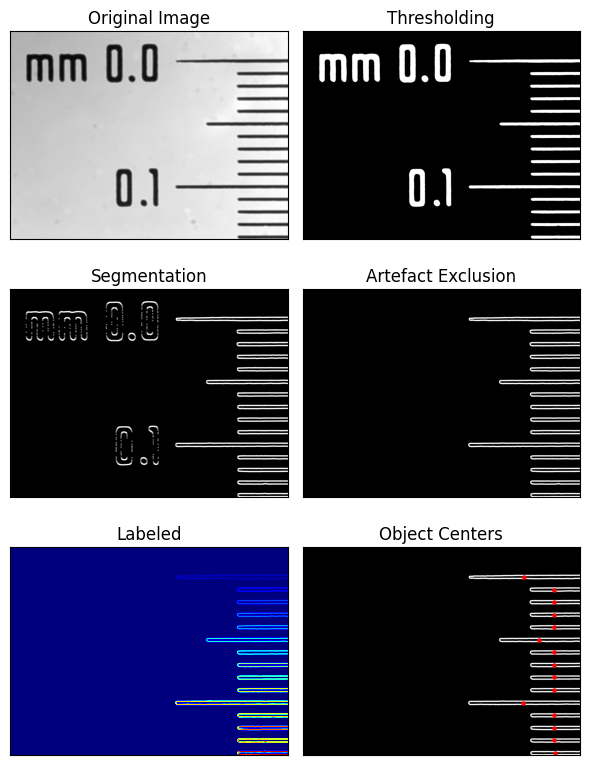

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(6, 8))
axs = axs.flatten()
axs[0].imshow(img, cmap='gray')
axs[0].set_title(f'Original Image')
axs[1].imshow(bin_img, cmap='gray')
axs[1].set_title(f'Thresholding')
axs[2].imshow(dip.Dilation(edge_img, 12), cmap='gray')
axs[2].set_title(f'Segmentation')
axs[3].imshow(mask, cmap='gray')
axs[3].set_title(f'Artefact Exclusion')

axs[4].imshow(labeled_mask, cmap='jet')
axs[4].set_title(f'Labeled')

axs[5].imshow(mask, cmap='gray')
axs[5].set_title(f'Object Centers')
axs[5].scatter(coords[:, 0] * 5.9, coords[:, 1] * 5.9, s=5, c='r')

for i in range(6):
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# Part 3.2.

In [20]:
images = {
    'ics': dip.ImageReadICS('images/scale-img.ics'),
    'tiff': dip.ImageReadTIFF('images/scale-img.tif')
}

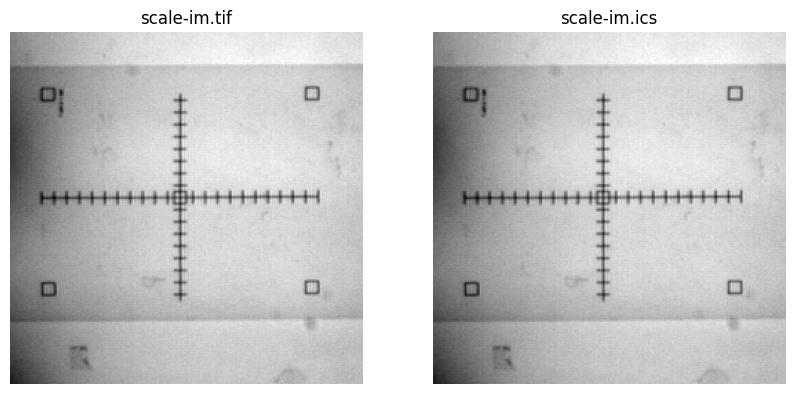

.tif dimensions:  (256, 256) 
.ics dimensions:  (256, 256)
mean difference: 0.00
St. dev of difference: 0.00
file size of scale-im.tif: 64.23 KB
file size of scale-im.ics: 0.27 KB


In [21]:
img_tif = dip.ImageReadTIFF('images/scale-img.tif')
img_ics = dip.ImageReadICS('images/scale-img.ics')

img_tif_data = np.asarray(img_tif)
img_ics_data = np.asarray(img_ics)

#images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_tif_data, cmap='gray')
plt.title('scale-im.tif')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_ics_data, cmap='gray')
plt.title('scale-im.ics')
plt.axis('off')

plt.show()

print(".tif dimensions: ", img_tif_data.shape, "\n.ics dimensions: ", img_ics_data.shape)


# diff calculation
difference = np.abs(img_tif_data - img_ics_data)
mean_difference = np.mean(difference)
std_difference = np.std(difference)
print(f"mean difference: {mean_difference:.2f}")
print(f"St. dev of difference: {std_difference:.2f}")

file_size_tif = os.path.getsize('images/scale-img.tif')
file_size_ics = os.path.getsize('images/scale-img.ics')

print(f"file size of scale-im.tif: {file_size_tif / 1024:.2f} KB")
print(f"file size of scale-im.ics: {file_size_ics / 1024:.2f} KB")



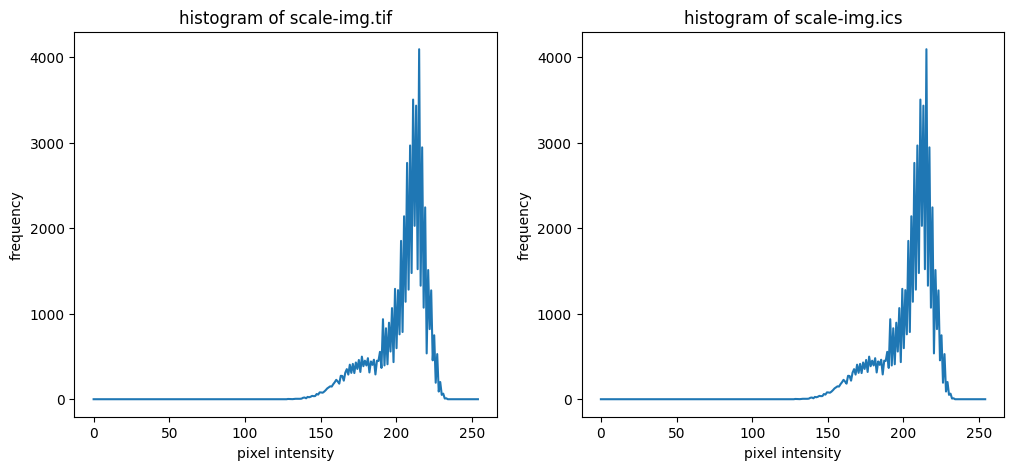

histogram correlation: 1.00


In [22]:
#compare hisograms
hist_tif = np.histogram(img_tif_data, bins=256, range=(0, 255))
hist_ics = np.histogram(img_ics_data, bins=256, range=(0, 255))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_tif[1][:-1], hist_tif[0], label='TIFF')
plt.title('histogram of scale-img.tif')
plt.xlabel('pixel intensity')
plt.ylabel('frequency')

plt.subplot(1, 2, 2)
plt.plot(hist_ics[1][:-1], hist_ics[0], label='ICS')
plt.title('histogram of scale-img.ics')
plt.xlabel('pixel intensity')
plt.ylabel('frequency')


plt.show()

# histogram diff
hist_diff = np.corrcoef(hist_tif[0], hist_ics[0])[0, 1]
print(f"histogram correlation: {hist_diff:.2f}")


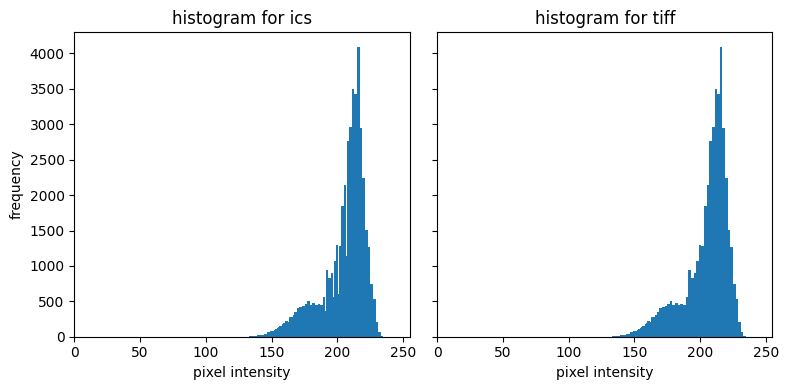

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

axs = axs.flatten()
file_names = ["rect1a.tif", "rect2a.tif", "rect3a.tif", "rect4a.tif"]


for idx, image_type in enumerate(['ics', 'tiff']):
    A = images[image_type]
    
    hist = dip.Histogram(A)
    
    bin_counts = hist.GetImage()
    
    bin_centers = hist.BinCenters()
    
    axs[idx].bar(bin_centers, bin_counts, width=2, align='center')
    axs[idx].set_title(f"histogram for {image_type}")
    axs[idx].set_xlabel('pixel intensity')
    axs[idx].set_xlim(xmin=0, xmax=255)

axs[0].set_ylabel('frequency')
fig.tight_layout()

# Part 3.3

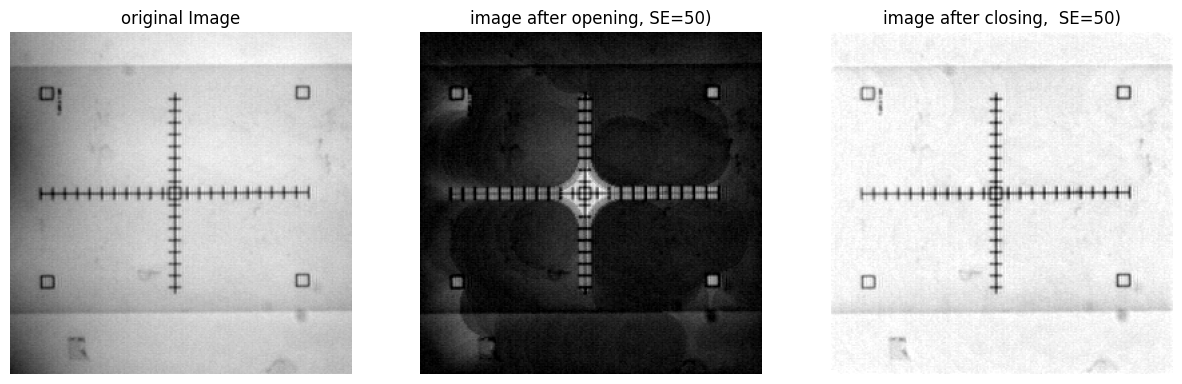

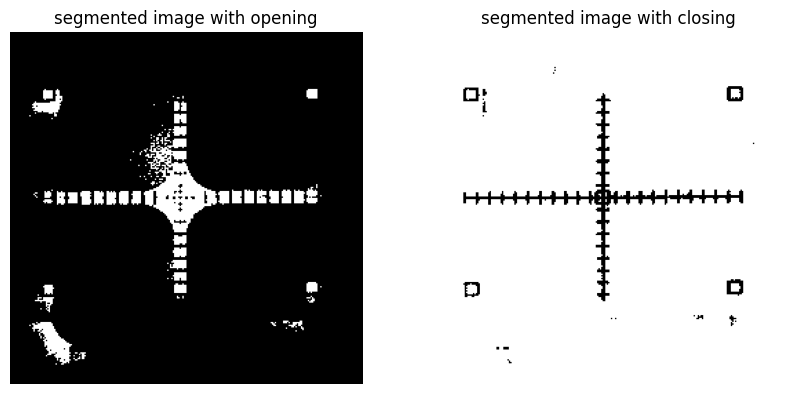

pixel size from method 1: 0.004998 mm per pixel
pixel size from method 2: 0.000562 mm per pixel


In [24]:
img = dip.ImageReadTIFF(f'{img_folder}/scale-img.tif')

# method 1: background subtraction with morphological opening
se_size1 = 50
se1 = dip.SE((se_size1, se_size1))
background1 = dip.Opening(img, se1)
enhanced_img1 = img - background1

# method 2:background subtraction with morphological closing
se_size2 = 50
se2 = dip.SE((se_size2, se_size2))
background2 = dip.Closing(img, se2)
enhanced_img2 = img - background2

# results of methods
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np.asarray(img), cmap='gray')
axs[0].set_title('original Image')
axs[1].imshow(np.asarray(enhanced_img1), cmap='gray')
axs[1].set_title(f'image after opening, SE={se_size1})')
axs[2].imshow(np.asarray(enhanced_img2), cmap='gray')
axs[2].set_title(f'image after closing,  SE={se_size2})')
for ax in axs:
    ax.axis('off')
plt.show()

# threshold segmentation
bin_img1 = dip.OtsuThreshold(enhanced_img1)
bin_img2 = dip.OtsuThreshold(enhanced_img2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asarray(bin_img1), cmap='gray')
axs[0].set_title('segmented image with opening')
axs[1].imshow(np.asarray(bin_img2), cmap='gray')
axs[1].set_title('segmented image with closing')
for ax in axs:
    ax.axis('off')
plt.show()

labeled_mask1 = dip.Label(bin_img1)
labeled_mask2 = dip.Label(bin_img2)

# measurements for method1
msr1 = dip.MeasurementTool.Measure(labeled_mask1, enhanced_img1, ['Gravity', 'GreyMajorAxes'])
coords1 = np.array([msr1[i+1]['Gravity'] for i in range(msr1.NumberOfObjects())])
y_coords1 = np.array([coord[1] for coord in coords1])
distances1 = np.diff(np.sort(y_coords1))
pixel_size1 = 0.01 / distances1.mean()
print(f"pixel size from method 1: {pixel_size1:.6f} mm per pixel")

# measurements for method2
msr2 = dip.MeasurementTool.Measure(labeled_mask2, enhanced_img2, ['Gravity', 'GreyMajorAxes'])
coords2 = np.array([msr2[i+1]['Gravity'] for i in range(msr2.NumberOfObjects())])
y_coords2 = np.array([coord[1] for coord in coords2])
distances2 = np.diff(np.sort(y_coords2))
pixel_size2 = 0.01 / distances2.mean()
print(f"pixel size from method 2: {pixel_size2:.6f} mm per pixel")

# Part 3.4.

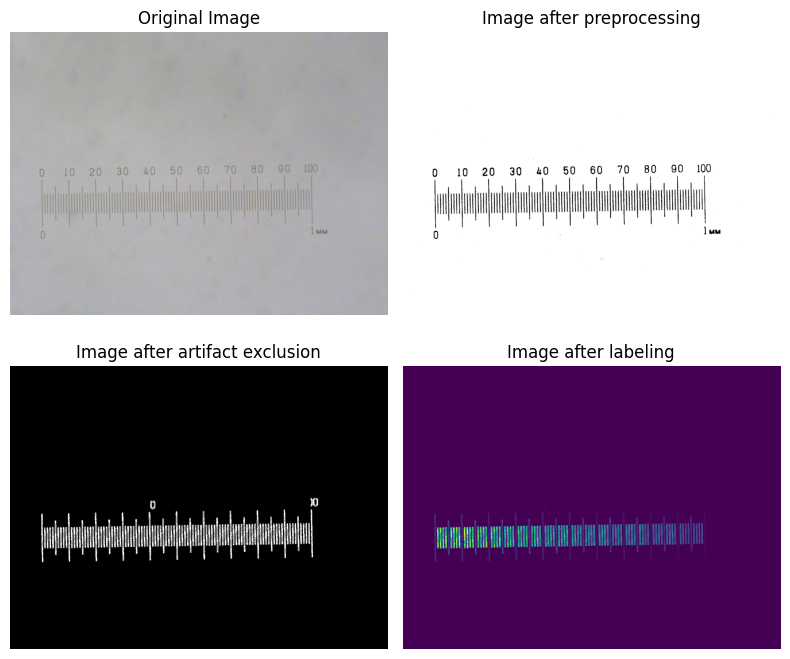

In [25]:
img_org = dip.ImageReadTIFF('images/CamIm04.tif')
img = dip.ColorSpaceManager.Convert(img_org, 'grey')

# BlackHat 
background = dip.Closing(img, 50)
enhanced_img = img - background
# Thresholding
bin_img = dip.OtsuThreshold(enhanced_img)

edge_img = dip.Abs(dip.SobelGradient(bin_img, dimension=0))
mask = dip.Dilation(edge_img, 1)
mask = dip.AreaOpening(mask, filterSize=300)
mask = dip.OtsuThreshold(mask)
labeled_mask = dip.Label(mask)

# results of methods
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
axs = axs.flatten()
axs[0].imshow(img_org)
axs[0].set_title('Original Image')
axs[1].imshow(bin_img, cmap='gray')
axs[1].set_title(f'Image after preprocessing')
axs[2].imshow(mask, cmap='gray')
axs[2].set_title(f'Image after artifact exclusion')
axs[3].imshow(labeled_mask)
axs[3].set_title(f'Image after labeling')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
msr = dip.MeasurementTool.Measure(labeled_mask, enhanced_img, ['Gravity', 'GreyMajorAxes'])
coords = np.array([msr[i+1]['Gravity'] for i in range(msr.NumberOfObjects())])
x_coords = np.array([coord[0] for coord in coords])
x_distances = np.diff(np.sort(x_coords)) ** 2
y_coords = np.array([coord[1] for coord in coords])
y_distances = np.diff(np.sort(y_coords)) ** 2
distances = np.sqrt(x_distances + y_distances) # Euclidean distance
pixel_size = 0.01 / distances.mean()
print(f"pixel size for CamIm04.tif: {pixel_size:.6f} mm per pixel")

pixel size for CamIm04.tif: 0.005890 mm per pixel
